## underfit-overfit

Interpretation by linear regression

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

num_train = 100
num_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5.0

In [2]:
x = nd.random.normal(shape=(num_train + num_test, 1))
X = nd.concat(x, nd.power(x, 2), nd.power(x, 3))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_w[2] * X[:, 2] + true_b
y += .1 * nd.random.normal(shape=y.shape)

('x:', x[:5], 'X:', X[:5], 'y:', y[:5])

('x:', 
 [[ 1.16307867]
  [ 0.48380461]
  [ 0.29956347]
  [ 0.15302546]
  [-1.16881478]]
 <NDArray 5x1 @cpu(0)>, 'X:', 
 [[ 1.16307867  1.35275197  1.57335699]
  [ 0.48380461  0.2340669   0.11324265]
  [ 0.29956347  0.08973827  0.02688231]
  [ 0.15302546  0.02341679  0.00358337]
  [-1.16881478  1.36612797 -1.59675062]]
 <NDArray 5x3 @cpu(0)>, 'y:', 
 [ 10.5346508    5.53009319   5.1570797    5.00668526 -10.06843472]
 <NDArray 5 @cpu(0)>)

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(X_train, X_test, y_train, y_test):
    # 线性回归模型
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    # 设一些默认参数
    learning_rate = 0.01
    epochs = 100
    batch_size = min(10, y_train.shape[0])
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size, shuffle=True)
    # 默认SGD和均方误差
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate})
    square_loss = gluon.loss.L2Loss()
    # 保存训练和测试损失
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(square_loss(
            net(X_train), y_train).mean().asscalar())
        test_loss.append(square_loss(
            net(X_test), y_test).mean().asscalar())
    # 打印结果
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned weight', net[0].weight.data(),
            'learned bias', net[0].bias.data())

fit

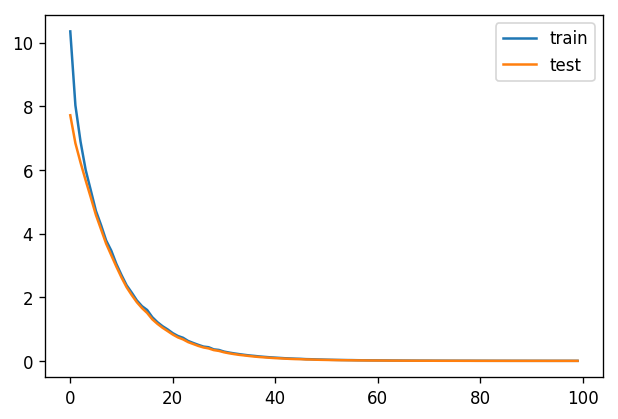

('learned weight', 
 [[ 1.16940939 -3.39058709  5.60412502]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 4.98542166]
 <NDArray 1 @cpu(0)>)

In [4]:
train(X[:num_train, :], X[num_train:, :], y[:num_train], y[num_train:])

underfit

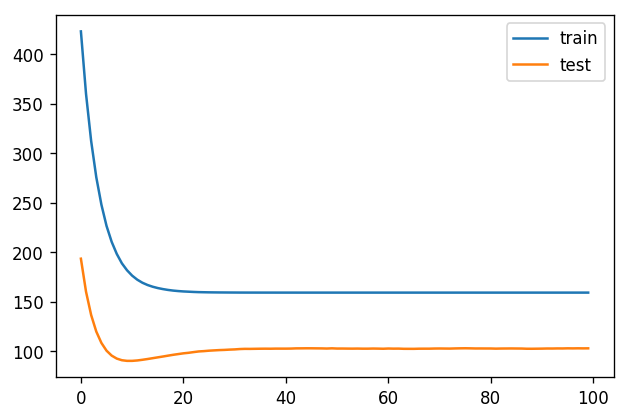

('learned weight', 
 [[ 22.68367577]]
 <NDArray 1x1 @cpu(0)>, 'learned bias', 
 [-0.66120291]
 <NDArray 1 @cpu(0)>)

In [5]:
train(x[:num_train, :], x[num_train:, :], y[:num_train], y[num_train:])

overfit

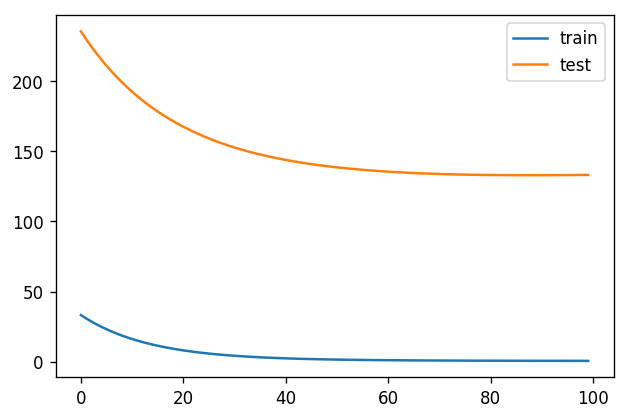

('learned weight', 
 [[ 2.05884552  1.92736697  2.0477407 ]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 2.4821291]
 <NDArray 1 @cpu(0)>)

In [6]:
train(X[0:2, :], X[num_train:, :], y[0:2], y[num_train:])

## regularization-scratch

Interpretation by logistic regression

In [7]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05


X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

In [8]:
import random
batch_size = 1
def data_iter(num_examples):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield X.take(j), y.take(j)

In [9]:
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    for param in params:
        param.attach_grad()
    return params

In [10]:
def L2_penalty(w, b):
    return ((w**2).sum() + b**2) / 2

In [11]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def net(X, w, b):
    return nd.dot(X, w) + b

def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

def test(net, params, X, y):
    return square_loss(net(X, *params), y).mean().asscalar()
    #return np.mean(square_loss(net(X, *params), y).asnumpy())

def train(lambd):
    epochs = 10
    learning_rate = 0.005
    w, b = params = init_params()
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter(num_train):
            with autograd.record():
                output = net(data, *params)
                loss = square_loss(
                    output, label) + lambd * L2_penalty(*params)
            loss.backward()
            sgd(params, learning_rate, batch_size)
        train_loss.append(test(net, params, X_train, y_train))
        test_loss.append(test(net, params, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return 'learned w[:10]:', w[:10].T, 'learned b:', b

without regularization

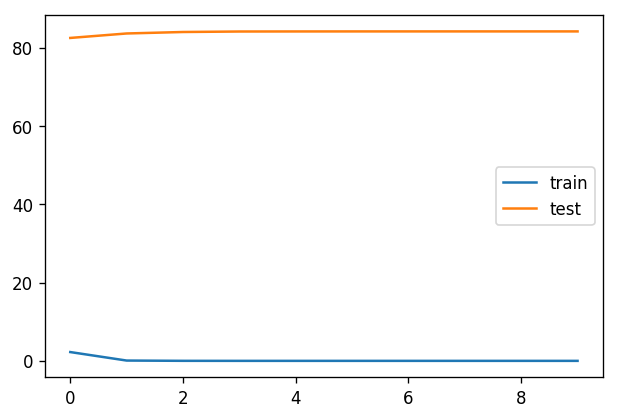

('learned w[:10]:', 
 [[ 0.02654596 -0.92490536 -2.57755566 -0.22590612 -0.202988   -0.07110693
    0.06192679 -0.08779521 -0.43305466 -1.32045341]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [-0.09419557]
 <NDArray 1 @cpu(0)>)

In [12]:
train(0)

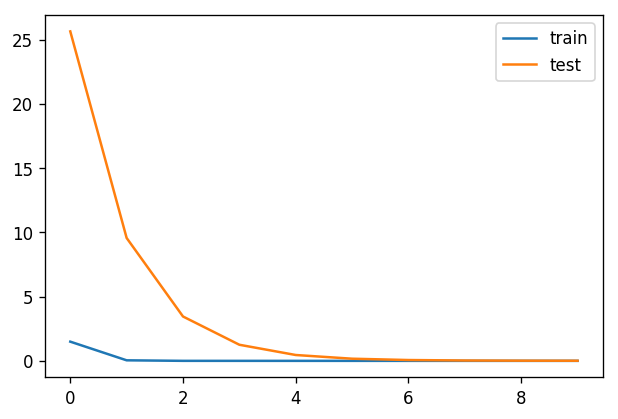

('learned w[:10]:', 
 [[-0.00391047 -0.00232602  0.00812822  0.01626859 -0.00663275  0.00219174
    0.0036415   0.00201697 -0.00890311 -0.00227397]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.00444688]
 <NDArray 1 @cpu(0)>)

In [13]:
train(5)

## regularization-gluon

In [14]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

In [15]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
dataset_train = gluon.data.ArrayDataset(X_train, y_train)
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)

square_loss = gluon.loss.L2Loss()

def test(net, X, y):
    return square_loss(net(X), y).mean().asscalar()

def train(weight_decay):
    epochs = 10
    learning_rate = 0.005
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.collect_params().initialize(mx.init.Normal(sigma=1))

    # 注意到这里 'wd'
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})

    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(test(net, X_train, y_train))
        test_loss.append(test(net, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()

    return ('learned w[:10]:', net[0].weight.data()[:,:10],
            'learned b:', net[0].bias.data())

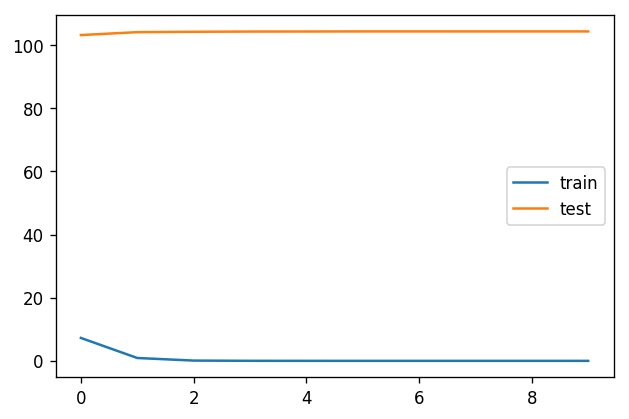

('learned w[:10]:', 
 [[-1.98230755  0.10768683 -0.95796871  0.22392957 -0.31485918  0.16134501
    0.17467454 -0.42611712 -0.0182256  -0.89444703]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.01043971]
 <NDArray 1 @cpu(0)>)

In [16]:
train(0)

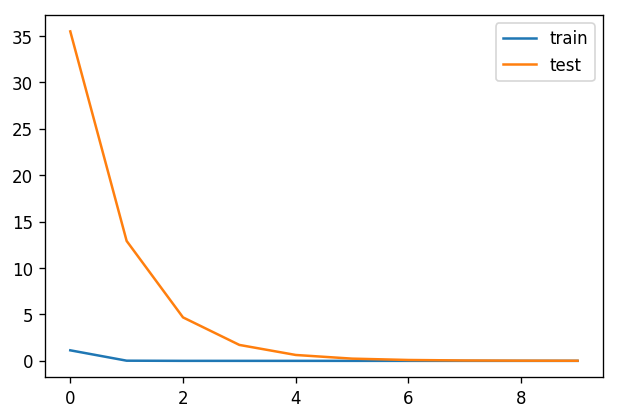

('learned w[:10]:', 
 [[  9.80840437e-03  -1.96589995e-03  -8.73846374e-03  -8.95807389e-05
    -1.24460226e-02  -2.32380931e-03   1.34183408e-03   1.10770471e-03
     7.54183347e-05  -9.24455002e-03]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.0063216]
 <NDArray 1 @cpu(0)>)

In [17]:
train(5)

## dropout

Interpretation by mlp

In [20]:
from mxnet import nd

def dropout(X, drop_probability):
    keep_probability = 1 - drop_probability
    assert 0 <= keep_probability <= 1
    # 这种情况下把全部元素都丢弃。
    if keep_probability == 0:
        return X.zeros_like()

    # 随机选择一部分该层的输出作为丢弃元素。
    mask = nd.random.uniform(
        0, 1.0, X.shape, ctx=X.context) < keep_probability
    # 保证 E[dropout(X)] == X
    scale =  1 / keep_probability
    return mask * X * scale

In [21]:
A = nd.arange(20).reshape((5,4))
dropout(A, 0.0)


[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]
 [ 12.  13.  14.  15.]
 [ 16.  17.  18.  19.]]
<NDArray 5x4 @cpu(0)>

In [22]:
dropout(A, 0.5)


[[  0.   0.   0.   0.]
 [  0.  10.   0.   0.]
 [ 16.  18.  20.  22.]
 [ 24.  26.  28.   0.]
 [ 32.   0.  36.  38.]]
<NDArray 5x4 @cpu(0)>

In [23]:
dropout(A, 1.0)


[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
<NDArray 5x4 @cpu(0)>

In [24]:
import numpy as np
class DataLoader(object):
    """similiar to gluon.data.DataLoader, but might be faster.

    The main difference this data loader tries to read more exmaples each
    time. But the limits are 1) all examples in dataset have the same shape, 2)
    data transfomer needs to process multiple examples at each time
    """
    def __init__(self, dataset, batch_size, shuffle, transform=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform

    def __iter__(self):
        data = self.dataset[:]
        X = data[0]
        y = nd.array(data[1])
        n = X.shape[0]
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            X = nd.array(X.asnumpy()[idx])
            y = nd.array(y.asnumpy()[idx])

        for i in range(n//self.batch_size):
            if self.transform is not None:
                yield self.transform(X[i*self.batch_size:(i+1)*self.batch_size], 
                                     y[i*self.batch_size:(i+1)*self.batch_size])
            else:
                yield (X[i*self.batch_size:(i+1)*self.batch_size],
                       y[i*self.batch_size:(i+1)*self.batch_size])

    def __len__(self):
        return len(self.dataset)//self.batch_size

In [25]:
def load_data_fashion_mnist(batch_size, resize=None, root="~/.mxnet/datasets/fashion-mnist"):
    """download the fashion mnist dataest and then load into memory"""
    def transform_mnist(data, label):
        # Transform a batch of examples.
        if resize:
            n = data.shape[0]
            new_data = nd.zeros((n, resize, resize, data.shape[3]))
            for i in range(n):
                new_data[i] = image.imresize(data[i], resize, resize)
            data = new_data
        # change data from batch x height x width x channel to batch x channel x height x width
        return nd.transpose(data.astype('float32'), (0,3,1,2))/255, label.astype('float32')

    mnist_train = gluon.data.vision.FashionMNIST(root=root, train=True, transform=None)
    mnist_test = gluon.data.vision.FashionMNIST(root=root, train=False, transform=None)
    # Transform later to avoid memory explosion. 
    train_data = DataLoader(mnist_train, batch_size, shuffle=True, transform=transform_mnist)
    test_data = DataLoader(mnist_test, batch_size, shuffle=False, transform=transform_mnist)
    return (train_data, test_data)

In [26]:
batch_size = 256
train_data, test_data = load_data_fashion_mnist(batch_size)

In [45]:
num_inputs = 28*28
num_outputs = 10

num_hidden1 = 256
num_hidden2 = 256
weight_scale = .01

W1 = nd.random_normal(shape=(num_inputs, num_hidden1), scale=weight_scale)
b1 = nd.zeros(num_hidden1)

W2 = nd.random_normal(shape=(num_hidden1, num_hidden2), scale=weight_scale)
b2 = nd.zeros(num_hidden2)

W3 = nd.random_normal(shape=(num_hidden2, num_outputs), scale=weight_scale)
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

In [28]:
drop_prob1 = 0.2
drop_prob2 = 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    # 第一层全连接。
    h1 = nd.relu(nd.dot(X, W1) + b1)
    # 在第一层全连接后添加丢弃层。
    h1 = dropout(h1, drop_prob1)
    # 第二层全连接。
    h2 = nd.relu(nd.dot(h1, W2) + b2)
    # 在第二层全连接后添加丢弃层。
    h2 = dropout(h2, drop_prob2)
    return nd.dot(h2, W3) + b3

In [44]:
# for test
def net2(X):
    X = X.reshape((-1, num_inputs))
    h1 = nd.relu(nd.dot(X, W1) + b1)
    h2 = nd.relu(nd.dot(h1, W2) + b2)
    return nd.dot(h2, W3) + b3

In [32]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [33]:
import mxnet as mx

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def _get_batch(batch, ctx):
    """return data and label on ctx"""
    if isinstance(batch, mx.io.DataBatch):
        data = batch.data[0]
        label = batch.label[0]
    else:
        data, label = batch
    return (gluon.utils.split_and_load(data, ctx),
            gluon.utils.split_and_load(label, ctx),
            data.shape[0])

def evaluate_accuracy(data_iterator, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc = nd.array([0])
    n = 0.
    if isinstance(data_iterator, mx.io.MXDataIter):
        data_iterator.reset()
    for batch in data_iterator:
        data, label, batch_size = _get_batch(batch, ctx)
        for X, y in zip(data, label):
            acc += nd.sum(net(X).argmax(axis=1)==y).copyto(mx.cpu())
            n += y.size
        acc.wait_to_read() # don't push too many operators into backend
    return acc.asscalar() / n

In [34]:
from mxnet import autograd
from mxnet import gluon

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

learning_rate = .5

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        SGD(params, learning_rate/batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data), test_acc))

Epoch 0. Loss: 1.167841, Train acc 0.544922, Test acc 0.762520
Epoch 1. Loss: 0.588168, Train acc 0.784038, Test acc 0.780950
Epoch 2. Loss: 0.494701, Train acc 0.819611, Test acc 0.828526
Epoch 3. Loss: 0.450187, Train acc 0.835687, Test acc 0.823818
Epoch 4. Loss: 0.425206, Train acc 0.844184, Test acc 0.844151


In [46]:
from mxnet import autograd
from mxnet import gluon

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

learning_rate = .5

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        SGD(params, learning_rate/batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net2)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data), test_acc))

Epoch 0. Loss: 1.164189, Train acc 0.546174, Test acc 0.779247
Epoch 1. Loss: 0.584461, Train acc 0.783804, Test acc 0.826322
Epoch 2. Loss: 0.495628, Train acc 0.817408, Test acc 0.820112
Epoch 3. Loss: 0.449645, Train acc 0.836321, Test acc 0.862480
Epoch 4. Loss: 0.423767, Train acc 0.846872, Test acc 0.839243


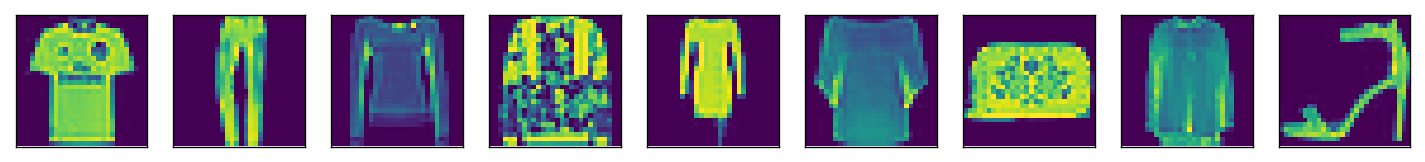

true labels
['t-shirt', 'trouser', 'pullover', 'pullover', 'dress,', 'pullover', 'bag', 'shirt', 'sandal']
predicted labels
['t-shirt', 'trouser', 'pullover', 't-shirt', 'dress,', 'shirt', 'bag', 'coat', 'sandal']


In [40]:
def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()
    
def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)
data, label = mnist_test[0:9]
show_images(data)
print('true labels')
print(get_text_labels(label))

predicted_labels = net(data).argmax(axis=1)
print('predicted labels')
print(get_text_labels(predicted_labels.asnumpy()))

## Dropout-gluon

In [47]:
from mxnet.gluon import nn

net = nn.Sequential()
drop_prob1 = 0.2
drop_prob2 = 0.5

with net.name_scope():
    net.add(nn.Flatten())
    # 第一层全连接。
    net.add(nn.Dense(256, activation="relu"))
    # 在第一层全连接后添加丢弃层。
    net.add(nn.Dropout(drop_prob1))
    # 第二层全连接。
    net.add(nn.Dense(256, activation="relu"))
    # 在第二层全连接后添加丢弃层。
    net.add(nn.Dropout(drop_prob2))
    net.add(nn.Dense(10))
net.initialize()

In [49]:
from mxnet import nd
from mxnet import autograd
from mxnet import gluon

batch_size = 256
train_data, test_data = load_data_fashion_mnist(batch_size)

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.5})

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data), test_acc))

Epoch 0. Loss: 0.809952, Train acc 0.700003, Test acc 0.814704
Epoch 1. Loss: 0.511172, Train acc 0.812767, Test acc 0.834736
Epoch 2. Loss: 0.454620, Train acc 0.833517, Test acc 0.860076
Epoch 3. Loss: 0.421490, Train acc 0.844668, Test acc 0.858874
Epoch 4. Loss: 0.395078, Train acc 0.855085, Test acc 0.859075
